# Проект: классификация

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, cross_val_score
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [431]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [432]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [433]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [434]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace({'\$': '', ',': '.',' ':''}, regex=True).astype(float)
display(df['balance'].head())
display(round(df['balance'].mean(),3))

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64

1529.129

### Задание 4

In [435]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df=df.fillna({'balance':df['balance'].median()})
display(df.isnull().sum())
display(round(df['balance'].mean(),3))


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

1526.936

### Задание 5

In [436]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
#display(df['education'].value_counts(), df['job'].value_counts())

#рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования 
# (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование)
mask_1 = (df['education']==df['education'].mode()[0])
mask_2 = (df['job']==df['job'].mode()[0])
best_job_ed_balance = round(df[mask_1 & mask_2]['balance'].mean(),3)
display(best_job_ed_balance)

1598.883

### Задание 6

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


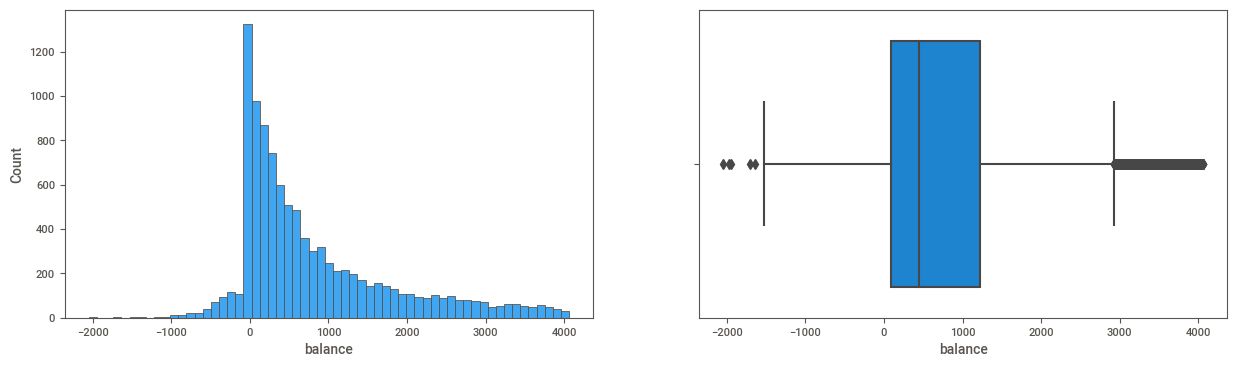

In [437]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print (f"Нижняя граница: {lower_bound}")
    upper_bound = quartile_3 + (iqr * 1.5)
    print (f"Верхняя граница: {upper_bound}")
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

#визулизация результата удаления выбросов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);

## Часть 2:  Разведывательный анализ

In [438]:
data = cleaned.copy()

### Задание 1

In [439]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(data['deposit'].value_counts())
display(data['deposit'].value_counts(normalize=True))

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

### Задания 2 и 3

In [440]:
#import sweetviz as sv
#report = sv.analyze(data)
#report.show_html()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


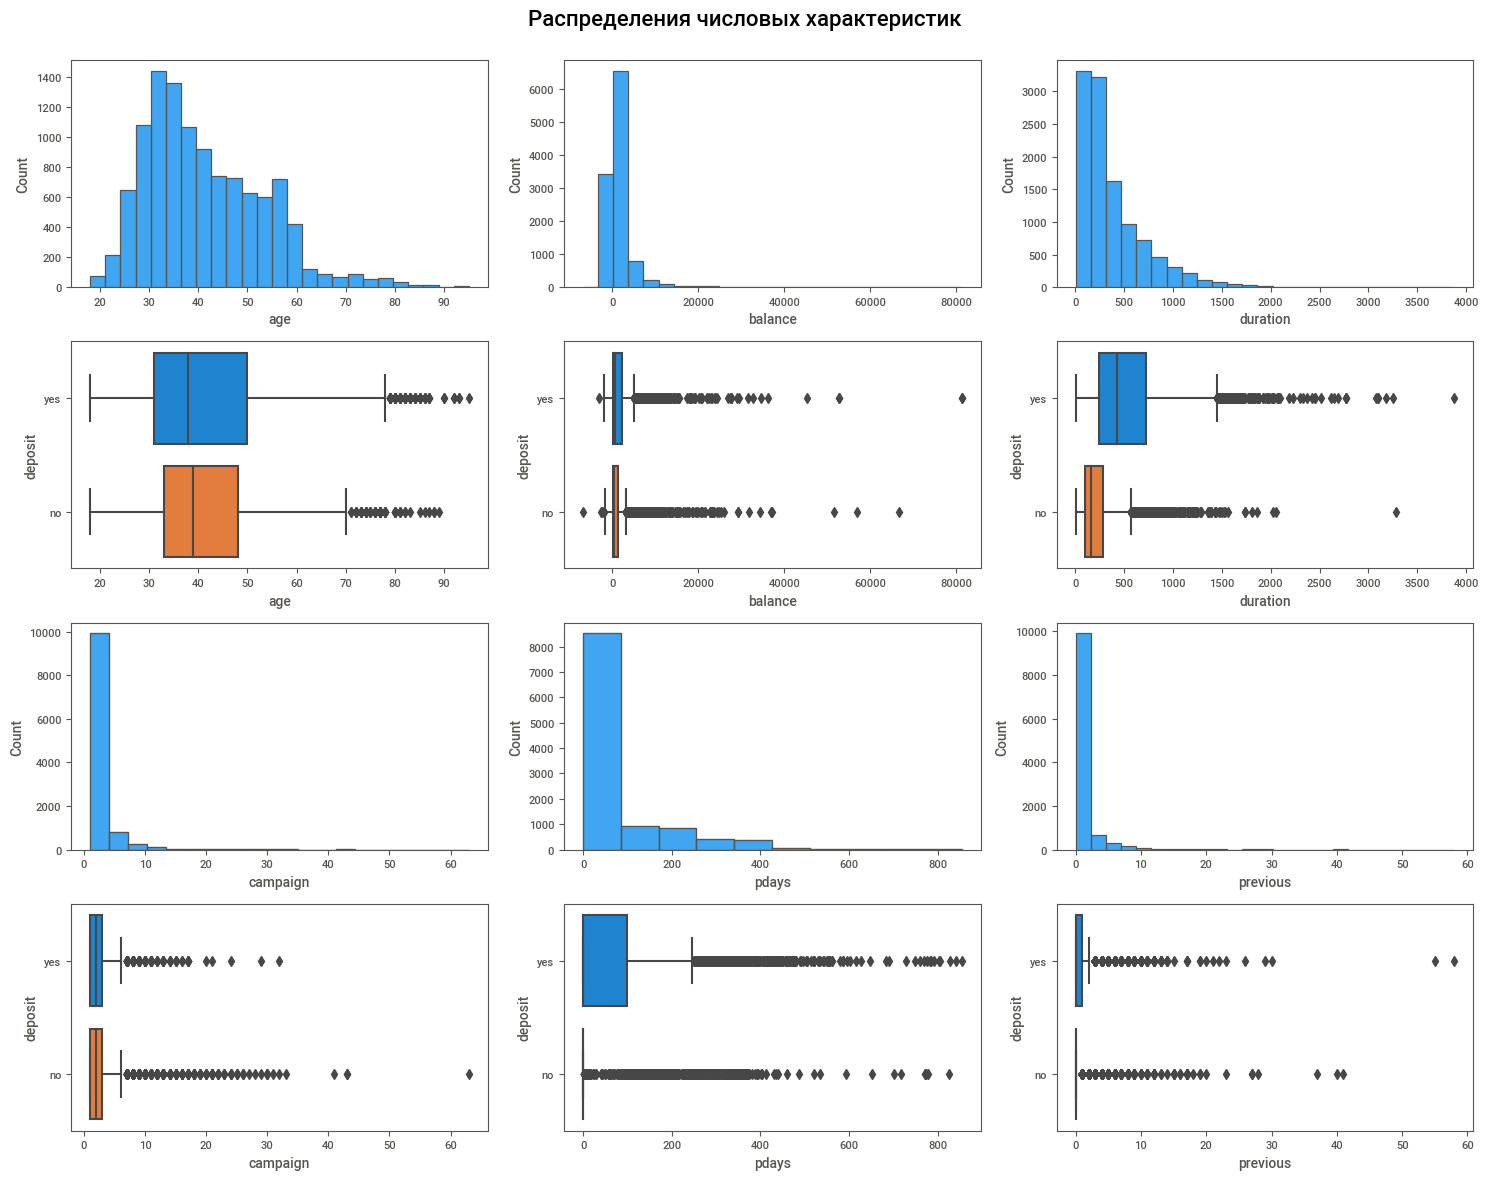

In [441]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(data.describe())

fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(df['age'], bins=25, ax=ax[0,0])       # Возраст
sns.histplot(df['balance'], bins=25, ax=ax[0,1])   # Баланс
sns.histplot(df['duration'], bins=25, ax=ax[0,2])  # Продолжительность контакта
sns.boxplot(data=df, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=df, x='balance', y='deposit', ax=ax[1,1])
sns.boxplot(data=df, x='duration', y='deposit', ax=ax[1,2])
sns.histplot(df['campaign'], bins=20, ax=ax[2,0])  # Количество контактов
sns.histplot(df['pdays'], bins=10, ax=ax[2,1])     # Количество дней после предыдущей кампании
sns.histplot(df['previous'], bins=25, ax=ax[2,2])  # Количество предыдущих контактов
sns.boxplot(data=df, x='campaign', y='deposit', ax=ax[3,0])
sns.boxplot(data=df, x='pdays', y='deposit', ax=ax[3,1])
sns.boxplot(data=df, x='previous', y='deposit', ax=ax[3,2])
plt.suptitle('Распределения числовых характеристик\n', fontsize=16)
plt.tight_layout()

### Общий вид распределений, выбросы
- Возраст (age). Пик распределения возраста приходится на 30-35 лет с достаточно большим количеством клиентов допенсионного возраста, количество клиентов старше 60 лет резко падает. Распределение с правой асимметрией в сторону старшего возраста.
- Баланс (balance). Есть небольшое количество отрацительных балансов. В остальном распределение логнормальное с преобладанием небольших балансов. Возможно, следует дополнительно убрать выбросы отрицательного баланса, расположенные левее границы распределения (менее 
).
- Продолжительность контакта (duration). Средняя продолжительность контакта около 5 мин. Распределение логнормальное. Возможно наличие выбросов - контакт более 30 мин.
- Количество контактов (campaign). Логнормальное. Выбросы - число контактов более 15.
- Количество дней с момента предыдущей кампании (pdays). Логнормальное. Выбросы - более 500 дней.
- Количество предыдущих контактов (previous). Логнормальное. Выбросы аналогичны признаку campaign - более 15.
Для более точного определения границ распределений и удаления выбросов желательно предварительно преобразовать часть признаков в логарифмическую шкалу и применить критерий Тьюки или 
.

### Влияние на целевой признак
Визуально значимые отличия в распределениях по отношению к целевому признаку - открытию депозита (deposit) - наблюдаются у нескольких признаков (см. диаграммы размаха). На вероятное открытие депозита указывает продолжительность контакта - чем он дольше, тем выше шансы положительного результата. Наоборот, большее количество контактов говорит о меньших шансах, т.е. попытки контактировать с клиентом более нескольких раз не имеют особого смысла, результат либо достигается при первых контактах, либо не достигается вообще. Более вероятно открытие депозита у клиентов с большей суммой на счете. Распределение признаков pdays и previous говорит о том, что старый друг лучше новых двух - большинство клиентов, не открывших депозит, относятся к новым (pdays=-1, previous=0). Распределение по возрасту для клиентов, не открывших депозит, имеет меньшую дисперсию по сравнению с открывшими, но медианные значения почти не отличаются.

### Задания 4 и 5

In [442]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
display(data.describe(include='object'))

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


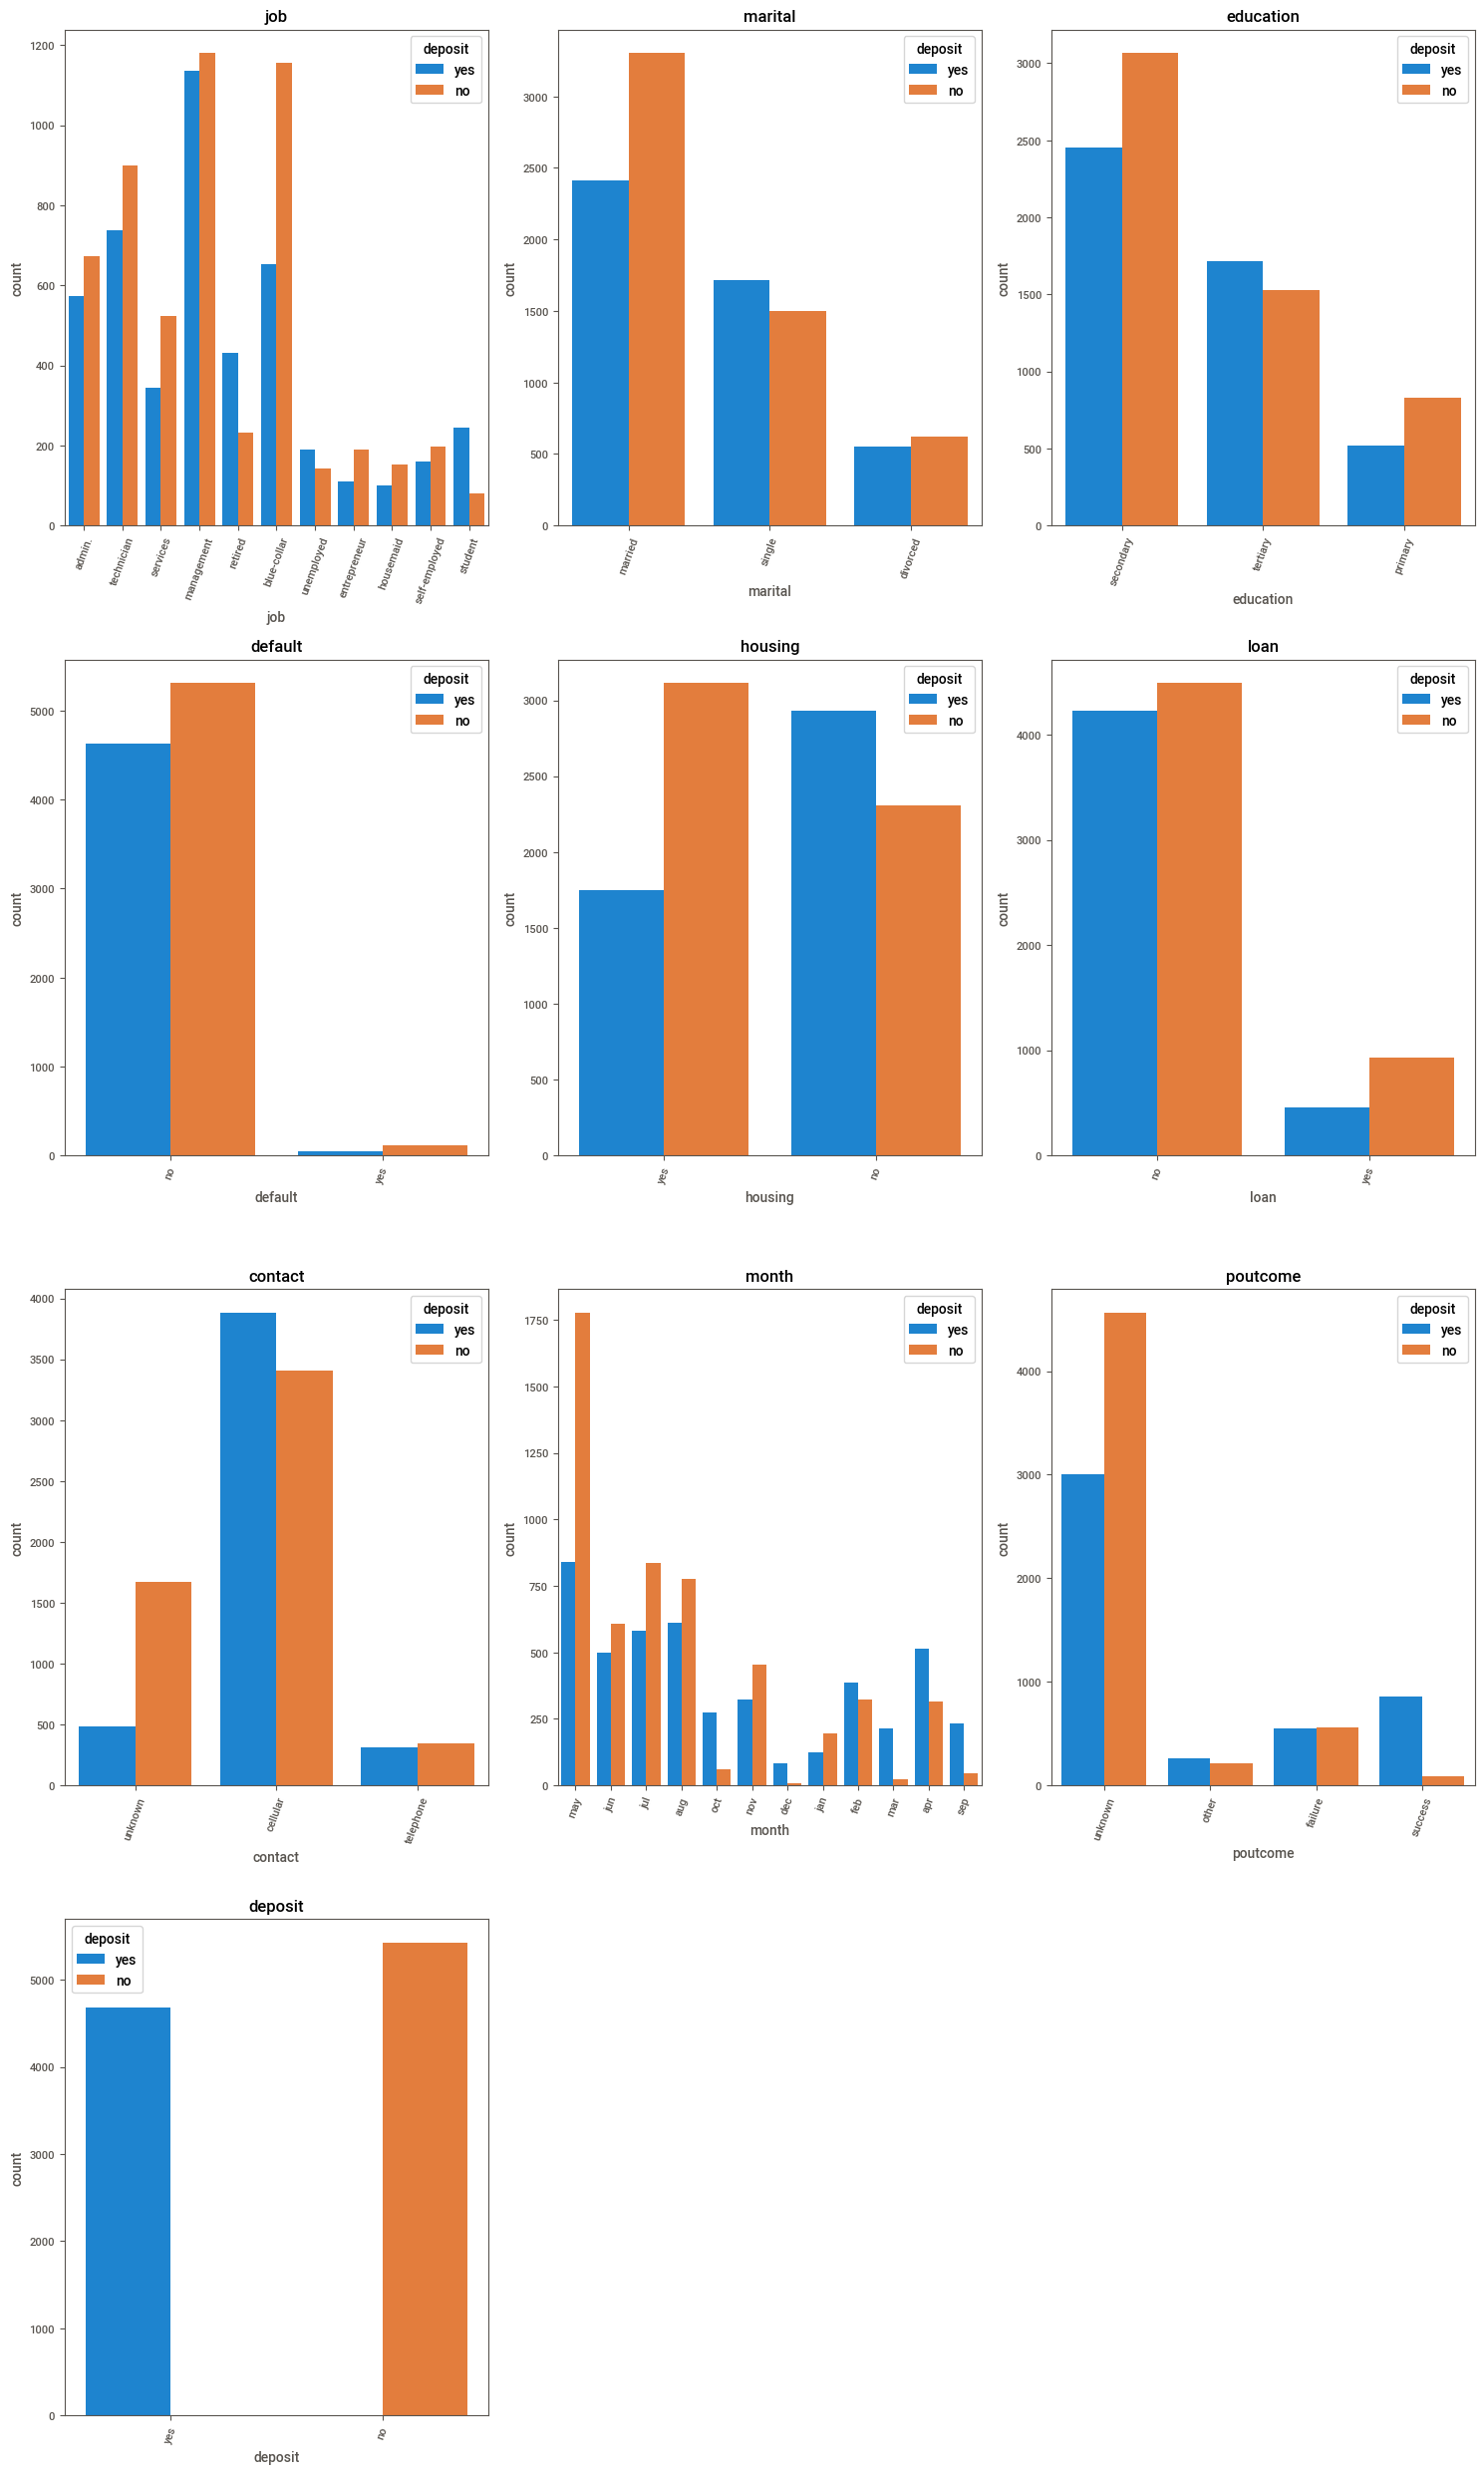

In [443]:
to_plot = list(data.select_dtypes(include=[object]).columns)

plt.figure(figsize=(15,75), facecolor='white')
pltnum =1
for feature in to_plot:
    ax = plt.subplot(12,3,pltnum)
    sns.countplot(x=feature,data=data, hue='deposit')#, order=data[feature].value_counts().index)
    plt.xlabel(feature)
    plt.title(feature)
    plt.xticks(rotation=70)
    plt.tight_layout()
    pltnum+=1
plt.show()

На рисунке видим соотношения различных категорий клиентов в разрезе достижения целевого признака - открытия депозита (deposit). Можно сказать, что аиболее склонны к открытию депозита следующие категории клиентов:

- пенсионеры и студенты (при небольшом относительном количестве и тех и других);
- клиенты, по которым был достигнут успех в предыдущей маркетинговой кампании - подавляющее большинство дают положительный результат и в текущей кампании;
- неженатые/незамужние клиенты, а также клиенты, не имеющие ипотеки (и те, и другие - в меньшей степени, однако в этих категориях число клиентов, открывших депозит, превышает число отрицательных результатов, что довольно нетипично для выборки в целом);
- клиенты, с которыми связывались по мобильному телефону - та же картина.

Наиболее неудачные результаты по привлечению к открытию депозита:

- "синие воротнички";
- клиенты с потребительскими кредитами

По какой-то причине наблюдаются значительные различия в успешности маркетинговой кампании по месяцам: исключительно успешные результаты в марте, апреле, сентябре, октябре и декабре, но существенный провал в мае. Данное обстоятельство требует дополнительного изучения в контексте построения модели машинного обучения - результаты могут быть связаны с конкретными "локальными" обстоятельствами маркетинговой кампании и не отражать общей тенденции (зависимости от времени года). Включение такой локальной зависимости в модель приведет к успешному предсказанию текущей ситуации, в том числе на тестовой выборке, однако нет гарантии, что новые данные будут соответствовать модели.

### Задание 6

In [444]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
(data.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack()* 100).sort_values('yes', ascending=False)  


deposit,no,yes
poutcome,,
success,8.888889,91.111111
other,44.906445,55.093555
failure,50.676285,49.323715
unknown,60.264201,39.735799


### Задание 7

In [445]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# процент отказов/согласия по месяцам:
(data.groupby('month')['deposit'].value_counts(normalize=True).unstack()* 100).sort_values('no', ascending=False)  

deposit,no,yes
month,,
may,67.863966,32.136034
jan,60.815047,39.184953
jul,58.956276,41.043724
nov,58.461538,41.538462
aug,55.956679,44.043321
jun,54.891304,45.108696
feb,45.557123,54.442877
apr,38.192771,61.807229
oct,18.507463,81.492537


Максимум отказов в процентном соотношении - май

### Задание 8

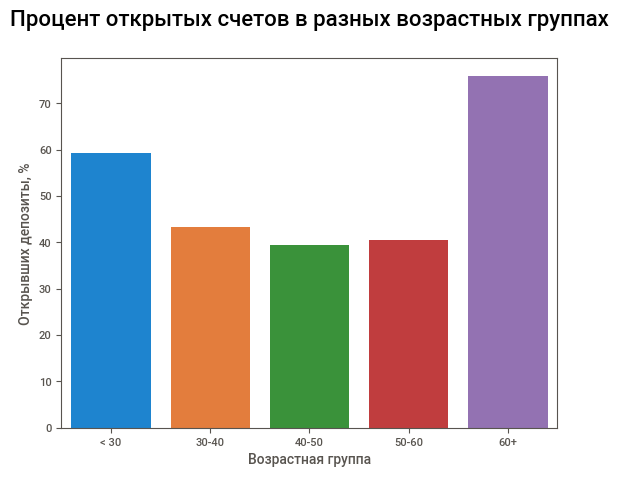

In [446]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(x):
    if x < 30:
        return '< 30'
    elif 30 <= x < 40:
        return '30-40'
    elif 40 <= x < 50:
        return '40-50'
    elif 50 <= x < 60:
        return '50-60' 
    else:
        return '60+'   

data['age_group'] = data['age'].apply(age_group)

piv_tab = (data.groupby('age_group')['deposit'].value_counts(normalize=True) \
    * 100).unstack().reset_index() # процент отказов/согласия по группам
ax = sns.barplot(
    data=piv_tab, x='age_group', y='yes', 
    order=['< 30', '30-40', '40-50', '50-60', '60+'])
ax.set(ylabel='Открывших депозиты, %', xlabel='Возрастная группа')
ax.set_title('Процент открытых счетов в разных возрастных группах\n', 
             fontsize=16);

### Задания 9 и 10

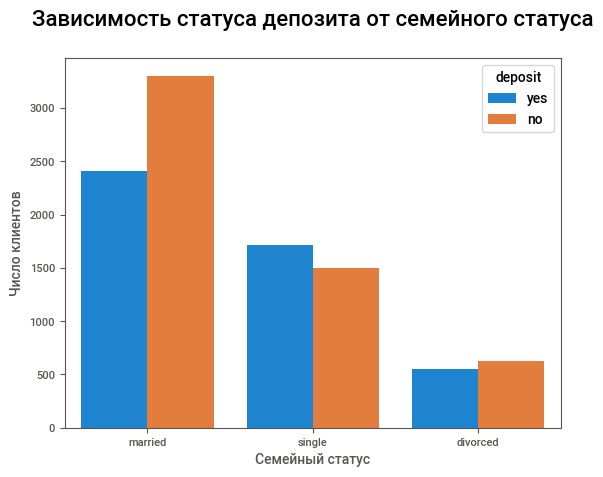

In [447]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
ax = sns.countplot(data=data, x='marital', hue='deposit')
ax.set(xlabel='Семейный статус', ylabel='Число клиентов')
ax.set_title('Зависимость статуса депозита от семейного статуса\n', fontsize=16);

Наиболее многочисленная группа - семейные, наиболее малочисленная - разведенные. Неженатые/незамужние более склонны к открытию депозита, чем семейные.

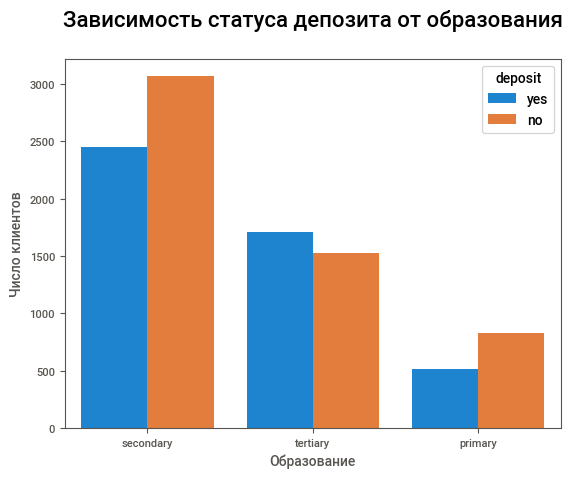

In [448]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ax = sns.countplot(data=data, x='education', hue='deposit')
ax.set(xlabel='Образование', ylabel='Число клиентов')
ax.set_title('Зависимость статуса депозита от образования\n', fontsize=16);

У большинства клиентов среднее образование. Более склонны к открытию депозита клиенты с высшим образованием.

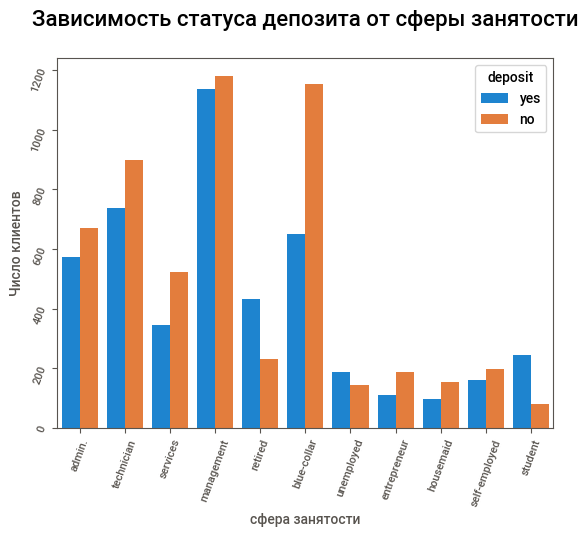

In [449]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
ax = sns.countplot(data=data, x='job', hue='deposit')
ax.tick_params(labelrotation=70)
ax.set(xlabel='сфера занятости', ylabel='Число клиентов')
ax.set_title('Зависимость статуса депозита от сферы занятости\n', fontsize=16);

Выделяется малый процент открытия депозитов у "синих воротничков" и большой - у пенсионеров и студентов. Важно отметить, что при этом "синие воротнички" составляют вторую по численности категорию клиентов (стоить подумать о способах привлечения этой категории).

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


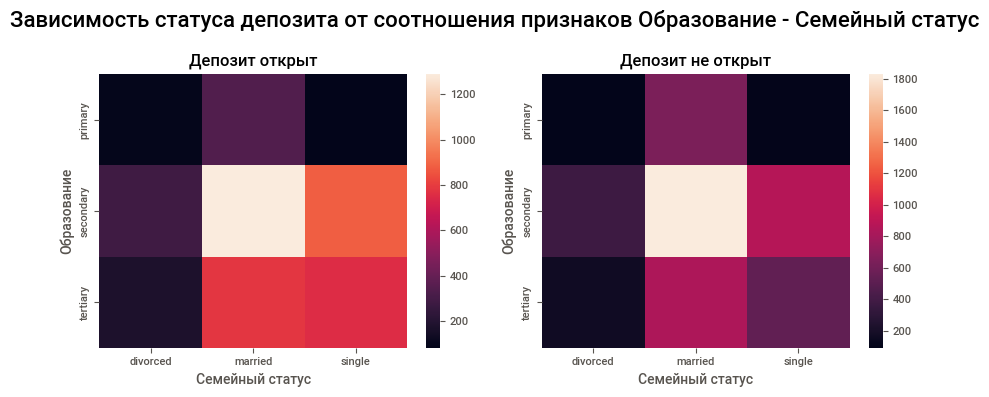

In [450]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_yes = data[data['deposit']=='yes']
df_no = data[data['deposit']=='no']
df_yes_pivot = df_yes.groupby(
    ['education', 'marital'])['marital'].count().unstack()
  
df_no_pivot = df_no.groupby(
    ['education', 'marital'])['marital'].count().unstack()

display(df_yes_pivot, df_no_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(df_yes_pivot, ax=ax[0])
sns.heatmap(df_no_pivot, ax=ax[1])
ax[0].set_title('Депозит открыт')
ax[1].set_title('Депозит не открыт')
ax[0].set(xlabel='Семейный статус', ylabel='Образование')
ax[1].set(xlabel='Семейный статус', ylabel='Образование')
plt.suptitle('Зависимость статуса депозита от соотношения признаков Образование - Семейный статус', fontsize=16)
plt.tight_layout()

В обеих категориях (открывшие и неоткрывшие депозит) преобладают семейные клиенты со средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [451]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
data['education'] = lab_enc.fit_transform(data['education'])
data['education'].sum()

11995

In [452]:
# Порядковое кодирование возрастных групп
data['age_group'] = pd.cut(data.age, [0,30,40,50,60,9999], 
                         labels=['<30', '30-40', '40-50', '50-60', '60+'])
label_enc = preprocessing.LabelEncoder()
data['age_group'] = label_enc.fit_transform(data['age_group'])

### Задания 2 и 3

In [453]:
# преобразуйте бинарные переменные в представление из нулей и единиц
data.replace({'yes': 1, 'no': 0}, inplace=True)

print(round(data['deposit'].std(), 3))
print(round(data['default'].mean()+data['housing'].mean()+data['loan'].mean(), 3))

0.499
0.635


### Задание 4

In [454]:
# создайте дамми-переменные
dummies = pd.get_dummies(data[[
    'job', 'marital', 'contact', 'month', 'poutcome']])
data = pd.concat([data, dummies], axis=1)

data.shape

(10105, 51)

In [455]:
# Удаляем преобразованные признаки типа object

obj_cols = list(data.select_dtypes('object').columns)
data.drop(columns=obj_cols, inplace=True)

### Задания 5 и 6

In [456]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_matrix = data.corr(method='kendall')
corr_matrix

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.131568,-0.003222,0.054599,-0.098679,-0.005770,-0.000398,-0.012486,0.019534,0.009186,...,0.023777,0.004829,-0.084555,0.030941,0.027215,0.007725,0.005904,-0.021831,0.026859,-0.011574
education,-0.131568,1.000000,-0.014479,0.039861,-0.096035,-0.053789,0.006277,0.001165,-0.005451,0.048543,...,-0.033397,0.052344,-0.103612,0.027016,0.026868,0.030389,0.017786,0.013744,0.066832,-0.064461
default,-0.003222,-0.014479,1.000000,-0.120464,0.009551,0.074786,0.016040,-0.003509,0.017447,-0.048488,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.054599,0.039861,-0.120464,1.000000,-0.076626,-0.099268,-0.011853,0.031699,-0.031433,0.071405,...,0.032022,0.035150,-0.081580,0.056571,0.050564,0.046855,0.029827,0.024399,0.075227,-0.084014
housing,-0.098679,-0.096035,0.009551,-0.076626,1.000000,0.072252,-0.015408,-0.004022,-0.004349,0.002391,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.005770,-0.053789,0.074786,-0.099268,0.072252,1.000000,0.017258,-0.029578,0.017742,-0.048066,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,-0.000398,0.006277,0.016040,-0.011853,-0.015408,0.017258,1.000000,-0.029504,0.085442,-0.068636,...,-0.149867,-0.038990,-0.015351,0.064248,0.061353,-0.056125,-0.059085,-0.008446,-0.038933,0.072899
duration,-0.012486,0.001165,-0.003509,0.031699,-0.004022,-0.029578,-0.029504,1.000000,-0.042062,0.007920,...,-0.018821,-0.017438,0.005014,-0.022453,0.003902,0.012688,-0.021211,0.002187,0.032610,-0.007682
campaign,0.019534,-0.005451,0.017447,-0.031433,-0.004349,0.017742,0.085442,-0.042062,1.000000,-0.109038,...,0.032415,-0.032690,-0.029045,-0.078995,-0.090656,-0.054489,-0.072043,-0.008962,-0.099955,0.123478
pdays,0.009186,0.048543,-0.048488,0.071405,0.002391,-0.048066,-0.068636,0.007920,-0.109038,1.000000,...,-0.087037,0.037303,-0.024471,0.040067,0.098529,0.122073,0.591383,0.364853,0.476393,-0.925560


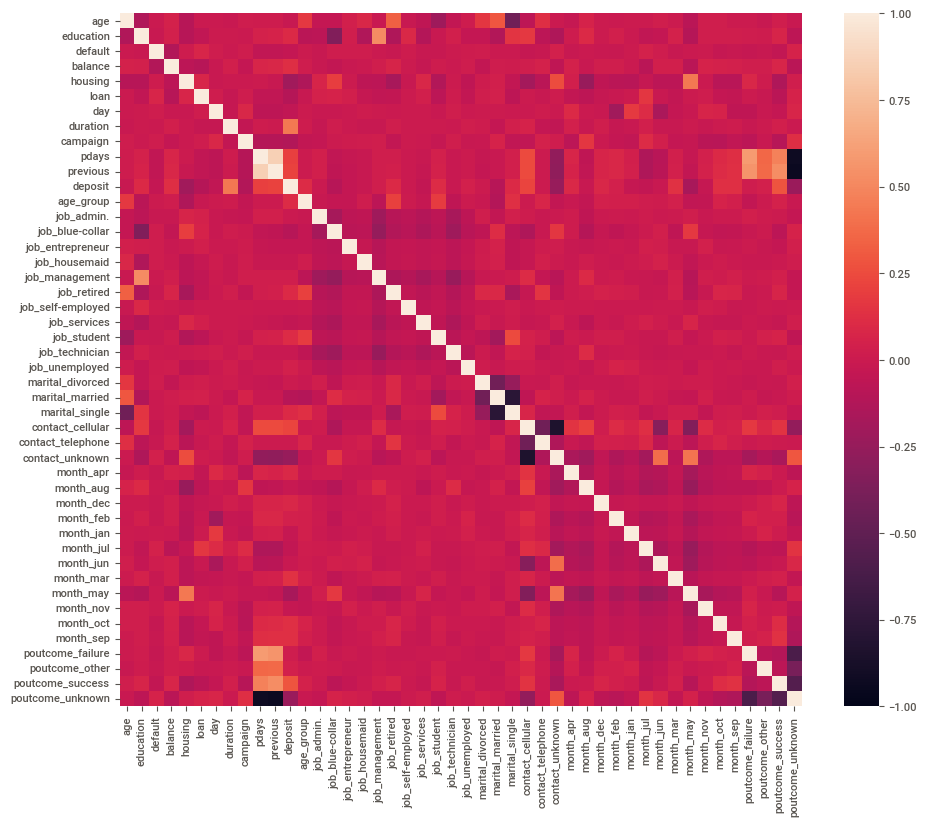

In [457]:
# Тепловая карта
fig = plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix,  vmin=-1, vmax=1);

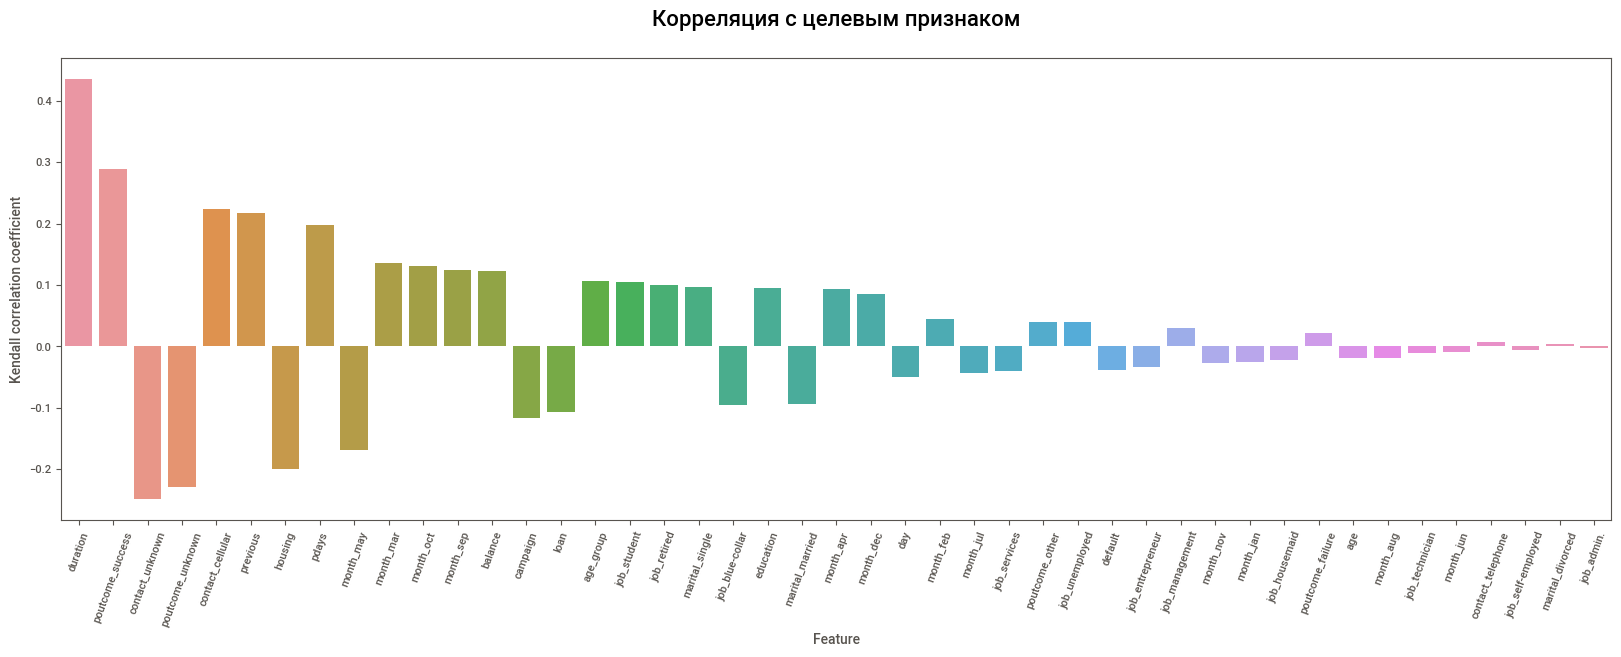

In [458]:
# Корреляция с целевым признаком

fig = plt.figure(figsize=(20,6))
plot_df = corr_matrix.drop('deposit')  # Убираем корреляцию "сам с собой"
feature_order = abs(plot_df['deposit']).sort_values(ascending=False).index
ax = sns.barplot(
    data=plot_df.reset_index(), x='index', y='deposit',
    order = feature_order)
plt.xticks(rotation=70)
ax.set(xlabel='Feature', ylabel='Kendall correlation coefficient')
ax.set_title('Корреляция с целевым признаком\n', fontsize=16);

### Задания 7 и 8

In [459]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
# Стратифицированное разбиение 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [460]:
# рассчитайте необходимые показатели
print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')
print("Среднее значение целевой переменной на тестовой выборке:",round(np.mean(y_test), 2))

Размер обучающей выборки: (6770, 45)
Размер тестовой выборки: (3335, 45)
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [461]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print(f'Selected features:\n {selected_cols}')
X_train = selector.transform(X_train)
X_test =selector.transform(X_test)

Selected features:
 ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [462]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

In [463]:
print(round(X_test_scaled[:, 0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [464]:
# обучите логистическую регрессию и рассчитайте метрики качества
logregr = linear_model.LogisticRegression(
    random_state=42, solver='sag', max_iter=1000)
logregr.fit(X_train_scaled, y_train)
y_train_pred = logregr.predict(X_train_scaled)
y_test_pred = logregr.predict(X_test_scaled)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [465]:
# обучите решающие деревья, настройте максимальную глубину
dtree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtree.fit(X_train_scaled, y_train)
y_train_pred = dtree.predict(X_train_scaled)
y_test_pred = dtree.predict(X_test_scaled)

print('accuracy на обучающем наборе:\n{:.2f}'.format(
    metrics.accuracy_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе:\n{:.2f}'.format(
    metrics.accuracy_score(y_test, y_test_pred)))

accuracy на обучающем наборе:
1.00
accuracy на тестовом наборе:
0.75


Максимальная точность на тесте: 0.81
Оптимальная глубина дерева: 6


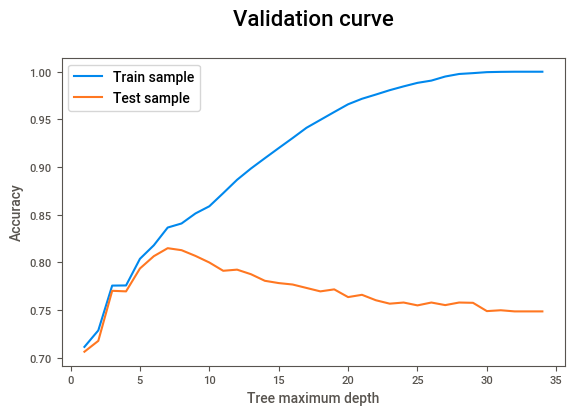

In [466]:
# Перебираем значения max_deph 
# Считаем accuracy на тренировочной и тестовой выборках
train_scores = []
test_scores = []
for max_depth in range(1,35):
    dtree = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=max_depth)
    dtree.fit(X_train_scaled, y_train)
    y_train_pred = dtree.predict(X_train_scaled)
    y_test_pred = dtree.predict(X_test_scaled)
    train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    test_scores.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Графики
max_depth = list(range(1,35))
fig = plt.figure(figsize=(6.5, 4))
ax = sns.lineplot(x=max_depth, y=train_scores, label='Train sample')
sns.lineplot(x=max_depth, y=test_scores, label='Test sample')
ax.set(xlabel='Tree maximum depth', ylabel='Accuracy')
ax.set_title('Validation curve\n', fontsize=16);

# Оптимальный параметр
print(f'Максимальная точность на тесте: {np.amax(test_scores):.2f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

### Задание 5

In [467]:
# подберите оптимальные параметры с помощью gridsearch
# Сетка параметров - по условию задания
estimator = tree.DecisionTreeClassifier(
    criterion='entropy', random_state=42)
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3,5,7]}
gsearch = GridSearchCV(
    estimator=estimator, param_grid=param_grid, scoring='f1')
gsearch.fit(X_train_scaled, y_train)

y_train_pred = gsearch.predict(X_train_scaled)
y_test_pred = gsearch.predict(X_test_scaled)

print(f'Наилучшие значения гиперпараметров: {gsearch.best_params_}')
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}
Обучающая выборка:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [468]:
# обучите на ваших данных случайный лес
# Параметры модели - по условию задания
rf = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    min_samples_leaf=5, 
    max_depth=10, 
    random_state=42)
rf.fit(X_train_scaled, y_train)

y_test_pred = rf.predict(X_test_scaled)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [469]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    min_samples_leaf=5,
    max_depth=5, 
    random_state=42)
gboost.fit(X_train_scaled, y_train)

y_test_pred = gboost.predict(X_test_scaled)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [470]:
# объедините уже известные вам алгоритмы с помощью стекинга 
dtree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
logregr = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [
    ('dtree', dtree), ('logregr', logregr), ('gboost', gboost)]

stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train_scaled, y_train)

y_test_pred = stacked.predict(X_test_scaled)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [471]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)
gboost.fit(X_train_scaled, y_train)
sorted(list(zip(selected_cols, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)

[('duration', 0.5071058721451659),
 ('poutcome_success', 0.11495825455712295),
 ('contact_unknown', 0.07258212753674755),
 ('balance', 0.05795212468091972),
 ('pdays', 0.05508257844117282),
 ('housing', 0.047725379385995796),
 ('age_group', 0.03990225428089568),
 ('month_mar', 0.027818612298223928),
 ('month_oct', 0.019880155415052104),
 ('month_may', 0.01524455070689359),
 ('campaign', 0.014776926675192212),
 ('month_sep', 0.013529992756931104),
 ('previous', 0.008438741473457433),
 ('contact_cellular', 0.003620125904267944),
 ('poutcome_unknown', 0.001382303741961252)]

### Задания 6,7,8

In [472]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# (реализуем для случайного леса)

def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = cross_val_score(
        model, X_train_scaled, y_train, cv=5, scoring='f1').mean()
    
    return score

# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RF_Classifier', direction='maximize')
study.optimize(obj_func, n_trials=10)
print(f'Лучшие параметры:\n{study.best_params}')

[I 2023-08-20 23:35:16,545] A new study created in memory with name: RF_Classifier
[I 2023-08-20 23:35:27,235] Trial 0 finished with value: 0.8242786399729709 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8242786399729709.
[I 2023-08-20 23:35:40,007] Trial 1 finished with value: 0.8277058875416656 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8277058875416656.
[I 2023-08-20 23:35:47,510] Trial 2 finished with value: 0.8245238752494883 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8277058875416656.
[I 2023-08-20 23:36:01,039] Trial 3 finished with value: 0.819955624378846 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8277058875416656.
[I 2023-08-20 23:36:22,178] Trial 4 finished with value: 0.8266535615983163 and parameters: {'n_estimator

Лучшие параметры:
{'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}


In [473]:
# Модель с лучшими параметрами  
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
rf_best.fit(X_train_scaled, y_train)
y_test_pred = rf_best.predict(X_test_scaled)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

